##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlowアドオンオプティマイザ：ConditionalGradient

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/addons/tutorials/optimizers_conditionalgradient"><img src="https://www.tensorflow.org/images/tf_logo_32px.png"> TensorFlow.orgで表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/addons/tutorials/optimizers_conditionalgradient.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png"> Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/addons/tutorials/optimizers_conditionalgradient.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示{</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/addons/tutorials/optimizers_conditionalgradient.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード/a0}</a></td>
</table>

# 概要

このノートブックでは、アドオンパッケージのConditional Gradientオプティマイザの使用方法を紹介します。

# ConditionalGradient

> 根本的な正則化の効果を出すために、ニューラルネットワークのパラメーターを制約することがトレーニングに有益であることが示されています。多くの場合、パラメーターはソフトペナルティ（制約充足を保証しない）または投影操作（計算コストが高い）によって制約されますが、Conditional Gradient（CG）オプティマイザは、費用のかかる投影ステップを必要とせずに、制約を厳密に適用します。これは、制約内のオブジェクトの線形近似を最小化することによって機能します。このノートブックでは、MNISTデータセットに対してCGオプティマイザを使用してフロベニウスノルム制約を適用する方法を紹介します。CGは、tensorflow APIとして利用可能になりました。オプティマイザの詳細は、https://arxiv.org/pdf/1803.06453.pdfを参照してください。


## セットアップ

In [2]:
!pip install -q -U tensorflow-addons

In [3]:
import tensorflow as tf
import tensorflow_addons as tfa
from matplotlib import pyplot as plt

In [4]:
# Hyperparameters
batch_size=64
epochs=10

# モデルの構築

In [5]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, input_shape=(784,), activation='relu', name='dense_1'),
    tf.keras.layers.Dense(64, activation='relu', name='dense_2'),
    tf.keras.layers.Dense(10, activation='softmax', name='predictions'),
])

# データの準備

In [6]:
# Load MNIST dataset as NumPy arrays
dataset = {}
num_validation = 10000
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocess the data
x_train = x_train.reshape(-1, 784).astype('float32') / 255
x_test = x_test.reshape(-1, 784).astype('float32') / 255

# カスタムコールバック関数の定義

In [7]:
def frobenius_norm(m):
    """This function is to calculate the frobenius norm of the matrix of all
    layer's weight.
  
    Args:
        m: is a list of weights param for each layers.
    """
    total_reduce_sum = 0
    for i in range(len(m)):
        total_reduce_sum = total_reduce_sum + tf.math.reduce_sum(m[i]**2)
    norm = total_reduce_sum**0.5
    return norm

In [8]:
CG_frobenius_norm_of_weight = []
CG_get_weight_norm = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda batch, logs: CG_frobenius_norm_of_weight.append(
        frobenius_norm(model_1.trainable_weights).numpy()))

# トレーニングと評価：オプティマイザとしてCGを使用

一般的なkerasオプティマイザを新しいtfaオプティマイザに置き換えるだけです。 

In [9]:
# Compile the model
model_1.compile(
    optimizer=tfa.optimizers.ConditionalGradient(
        learning_rate=0.99949, lambda_=203),  # Utilize TFA optimizer
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

history_cg = model_1.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    epochs=epochs,
    callbacks=[CG_get_weight_norm])

Epoch 1/10


  1/938 [..............................] - ETA: 14:20 - loss: 2.3332 - accuracy: 0.0312

 22/938 [..............................] - ETA: 2s - loss: 2.0080 - accuracy: 0.3454   

 43/938 [>.............................] - ETA: 2s - loss: 1.7301 - accuracy: 0.4610

 65/938 [=>............................] - ETA: 2s - loss: 1.5362 - accuracy: 0.5292

 88/938 [=>............................] - ETA: 2s - loss: 1.3951 - accuracy: 0.5759

112/938 [==>...........................] - ETA: 1s - loss: 1.2863 - accuracy: 0.6109

134/938 [===>..........................] - ETA: 1s - loss: 1.2093 - accuracy: 0.6354

157/938 [====>.........................] - ETA: 1s - loss: 1.1435 - accuracy: 0.6561

179/938 [====>.........................] - ETA: 1s - loss: 1.0909 - accuracy: 0.6725

201/938 [=====>........................] - ETA: 1s - loss: 1.0459 - accuracy: 0.6864

224/938 [======>.......................] - ETA: 1s - loss: 1.0053 - accuracy: 0.6988

247/938 [======>.......................] - ETA: 1s - loss: 0.9701 - accuracy: 0.7095

270/938 [=======>......................] - ETA: 1s - loss: 0.9391 - accuracy: 0.7189

293/938 [========>.....................] - ETA: 1s - loss: 0.9115 - accuracy: 0.7271

316/938 [=========>....................] - ETA: 1s - loss: 0.8868 - accuracy: 0.7345

337/938 [=========>....................] - ETA: 1s - loss: 0.8660 - accuracy: 0.7407

360/938 [==========>...................] - ETA: 1s - loss: 0.8450 - accuracy: 0.7470

382/938 [===========>..................] - ETA: 1s - loss: 0.8266 - accuracy: 0.7525

404/938 [===========>..................] - ETA: 1s - loss: 0.8095 - accuracy: 0.7576

426/938 [============>.................] - ETA: 1s - loss: 0.7935 - accuracy: 0.7624

448/938 [=============>................] - ETA: 1s - loss: 0.7786 - accuracy: 0.7668

471/938 [==============>...............] - ETA: 1s - loss: 0.7642 - accuracy: 0.7711

493/938 [==============>...............] - ETA: 1s - loss: 0.7512 - accuracy: 0.7750

516/938 [===============>..............] - ETA: 0s - loss: 0.7384 - accuracy: 0.7788

539/938 [================>.............] - ETA: 0s - loss: 0.7264 - accuracy: 0.7824

561/938 [================>.............] - ETA: 0s - loss: 0.7156 - accuracy: 0.7857

583/938 [=================>............] - ETA: 0s - loss: 0.7053 - accuracy: 0.7888

606/938 [==================>...........] - ETA: 0s - loss: 0.6951 - accuracy: 0.7918

628/938 [===================>..........] - ETA: 0s - loss: 0.6860 - accuracy: 0.7946

650/938 [===================>..........] - ETA: 0s - loss: 0.6773 - accuracy: 0.7972

672/938 [====================>.........] - ETA: 0s - loss: 0.6689 - accuracy: 0.7997

695/938 [=====================>........] - ETA: 0s - loss: 0.6606 - accuracy: 0.8022

718/938 [=====================>........] - ETA: 0s - loss: 0.6527 - accuracy: 0.8045

741/938 [======================>.......] - ETA: 0s - loss: 0.6451 - accuracy: 0.8068

764/938 [=======================>......] - ETA: 0s - loss: 0.6378 - accuracy: 0.8090

786/938 [========================>.....] - ETA: 0s - loss: 0.6311 - accuracy: 0.8109

807/938 [========================>.....] - ETA: 0s - loss: 0.6250 - accuracy: 0.8128

830/938 [=========================>....] - ETA: 0s - loss: 0.6185 - accuracy: 0.8147

853/938 [==========================>...] - ETA: 0s - loss: 0.6123 - accuracy: 0.8165

876/938 [===========================>..] - ETA: 0s - loss: 0.6063 - accuracy: 0.8183

900/938 [===========================>..] - ETA: 0s - loss: 0.6003 - accuracy: 0.8201

924/938 [============================>.] - ETA: 0s - loss: 0.5944 - accuracy: 0.8219

938/938 [==============================] - 4s 3ms/step - loss: 0.5909 - accuracy: 0.8229 - val_loss: 0.2154 - val_accuracy: 0.9306


Epoch 2/10
  1/938 [..............................] - ETA: 2s - loss: 0.0733 - accuracy: 0.9844

 24/938 [..............................] - ETA: 1s - loss: 0.1723 - accuracy: 0.9520

 47/938 [>.............................] - ETA: 1s - loss: 0.1779 - accuracy: 0.9510

 68/938 [=>............................] - ETA: 1s - loss: 0.1817 - accuracy: 0.9493

 90/938 [=>............................] - ETA: 1s - loss: 0.1846 - accuracy: 0.9476

113/938 [==>...........................] - ETA: 1s - loss: 0.1860 - accuracy: 0.9465

135/938 [===>..........................] - ETA: 1s - loss: 0.1872 - accuracy: 0.9457

159/938 [====>.........................] - ETA: 1s - loss: 0.1887 - accuracy: 0.9448

181/938 [====>.........................] - ETA: 1s - loss: 0.1901 - accuracy: 0.9442

202/938 [=====>........................] - ETA: 1s - loss: 0.1914 - accuracy: 0.9437

223/938 [======>.......................] - ETA: 1s - loss: 0.1925 - accuracy: 0.9432

245/938 [======>.......................] - ETA: 1s - loss: 0.1932 - accuracy: 0.9429

268/938 [=======>......................] - ETA: 1s - loss: 0.1940 - accuracy: 0.9426

289/938 [========>.....................] - ETA: 1s - loss: 0.1946 - accuracy: 0.9423

311/938 [========>.....................] - ETA: 1s - loss: 0.1953 - accuracy: 0.9420

333/938 [=========>....................] - ETA: 1s - loss: 0.1959 - accuracy: 0.9417

355/938 [==========>...................] - ETA: 1s - loss: 0.1965 - accuracy: 0.9415

377/938 [===========>..................] - ETA: 1s - loss: 0.1970 - accuracy: 0.9414

399/938 [===========>..................] - ETA: 1s - loss: 0.1973 - accuracy: 0.9412

421/938 [============>.................] - ETA: 1s - loss: 0.1976 - accuracy: 0.9411

444/938 [=============>................] - ETA: 1s - loss: 0.1978 - accuracy: 0.9409

467/938 [=============>................] - ETA: 1s - loss: 0.1980 - accuracy: 0.9409

489/938 [==============>...............] - ETA: 1s - loss: 0.1981 - accuracy: 0.9408

509/938 [===============>..............] - ETA: 0s - loss: 0.1982 - accuracy: 0.9407

530/938 [===============>..............] - ETA: 0s - loss: 0.1982 - accuracy: 0.9407

551/938 [================>.............] - ETA: 0s - loss: 0.1981 - accuracy: 0.9406

574/938 [=================>............] - ETA: 0s - loss: 0.1981 - accuracy: 0.9406

596/938 [==================>...........] - ETA: 0s - loss: 0.1980 - accuracy: 0.9406

618/938 [==================>...........] - ETA: 0s - loss: 0.1979 - accuracy: 0.9406

641/938 [===================>..........] - ETA: 0s - loss: 0.1979 - accuracy: 0.9406

663/938 [====================>.........] - ETA: 0s - loss: 0.1978 - accuracy: 0.9406

685/938 [====================>.........] - ETA: 0s - loss: 0.1977 - accuracy: 0.9406

708/938 [=====================>........] - ETA: 0s - loss: 0.1976 - accuracy: 0.9407

731/938 [======================>.......] - ETA: 0s - loss: 0.1975 - accuracy: 0.9407

754/938 [=======================>......] - ETA: 0s - loss: 0.1973 - accuracy: 0.9407

777/938 [=======================>......] - ETA: 0s - loss: 0.1972 - accuracy: 0.9407

800/938 [========================>.....] - ETA: 0s - loss: 0.1971 - accuracy: 0.9408

823/938 [=========================>....] - ETA: 0s - loss: 0.1969 - accuracy: 0.9408

846/938 [==========================>...] - ETA: 0s - loss: 0.1968 - accuracy: 0.9408

869/938 [==========================>...] - ETA: 0s - loss: 0.1966 - accuracy: 0.9409

893/938 [===========================>..] - ETA: 0s - loss: 0.1965 - accuracy: 0.9409

917/938 [============================>.] - ETA: 0s - loss: 0.1964 - accuracy: 0.9410

938/938 [==============================] - 2s 3ms/step - loss: 0.1963 - accuracy: 0.9410 - val_loss: 0.1732 - val_accuracy: 0.9437


Epoch 3/10
  1/938 [..............................] - ETA: 2s - loss: 0.0976 - accuracy: 0.9688

 23/938 [..............................] - ETA: 2s - loss: 0.1550 - accuracy: 0.9527

 46/938 [>.............................] - ETA: 1s - loss: 0.1619 - accuracy: 0.9506

 69/938 [=>............................] - ETA: 1s - loss: 0.1626 - accuracy: 0.9509

 91/938 [=>............................] - ETA: 1s - loss: 0.1620 - accuracy: 0.9514

113/938 [==>...........................] - ETA: 1s - loss: 0.1617 - accuracy: 0.9517

134/938 [===>..........................] - ETA: 1s - loss: 0.1616 - accuracy: 0.9518

155/938 [===>..........................] - ETA: 1s - loss: 0.1615 - accuracy: 0.9518

176/938 [====>.........................] - ETA: 1s - loss: 0.1613 - accuracy: 0.9519

197/938 [=====>........................] - ETA: 1s - loss: 0.1613 - accuracy: 0.9520

218/938 [=====>........................] - ETA: 1s - loss: 0.1615 - accuracy: 0.9519

239/938 [======>.......................] - ETA: 1s - loss: 0.1616 - accuracy: 0.9519

260/938 [=======>......................] - ETA: 1s - loss: 0.1616 - accuracy: 0.9520

280/938 [=======>......................] - ETA: 1s - loss: 0.1616 - accuracy: 0.9520

300/938 [========>.....................] - ETA: 1s - loss: 0.1616 - accuracy: 0.9521

319/938 [=========>....................] - ETA: 1s - loss: 0.1616 - accuracy: 0.9521

339/938 [=========>....................] - ETA: 1s - loss: 0.1616 - accuracy: 0.9521

360/938 [==========>...................] - ETA: 1s - loss: 0.1615 - accuracy: 0.9521

381/938 [===========>..................] - ETA: 1s - loss: 0.1614 - accuracy: 0.9521

402/938 [===========>..................] - ETA: 1s - loss: 0.1614 - accuracy: 0.9521

423/938 [============>.................] - ETA: 1s - loss: 0.1613 - accuracy: 0.9521

444/938 [=============>................] - ETA: 1s - loss: 0.1612 - accuracy: 0.9521

465/938 [=============>................] - ETA: 1s - loss: 0.1611 - accuracy: 0.9521

486/938 [==============>...............] - ETA: 1s - loss: 0.1610 - accuracy: 0.9522

507/938 [===============>..............] - ETA: 1s - loss: 0.1609 - accuracy: 0.9522

528/938 [===============>..............] - ETA: 1s - loss: 0.1608 - accuracy: 0.9522

548/938 [================>.............] - ETA: 0s - loss: 0.1607 - accuracy: 0.9523

569/938 [=================>............] - ETA: 0s - loss: 0.1605 - accuracy: 0.9523

591/938 [=================>............] - ETA: 0s - loss: 0.1604 - accuracy: 0.9524

610/938 [==================>...........] - ETA: 0s - loss: 0.1603 - accuracy: 0.9524

630/938 [===================>..........] - ETA: 0s - loss: 0.1601 - accuracy: 0.9525

651/938 [===================>..........] - ETA: 0s - loss: 0.1600 - accuracy: 0.9525

672/938 [====================>.........] - ETA: 0s - loss: 0.1598 - accuracy: 0.9526

693/938 [=====================>........] - ETA: 0s - loss: 0.1597 - accuracy: 0.9526

714/938 [=====================>........] - ETA: 0s - loss: 0.1596 - accuracy: 0.9527

735/938 [======================>.......] - ETA: 0s - loss: 0.1594 - accuracy: 0.9527

756/938 [=======================>......] - ETA: 0s - loss: 0.1593 - accuracy: 0.9527

777/938 [=======================>......] - ETA: 0s - loss: 0.1592 - accuracy: 0.9528

797/938 [========================>.....] - ETA: 0s - loss: 0.1590 - accuracy: 0.9528

818/938 [=========================>....] - ETA: 0s - loss: 0.1589 - accuracy: 0.9529

838/938 [=========================>....] - ETA: 0s - loss: 0.1588 - accuracy: 0.9529

858/938 [==========================>...] - ETA: 0s - loss: 0.1587 - accuracy: 0.9530

879/938 [===========================>..] - ETA: 0s - loss: 0.1585 - accuracy: 0.9530

900/938 [===========================>..] - ETA: 0s - loss: 0.1584 - accuracy: 0.9530

921/938 [============================>.] - ETA: 0s - loss: 0.1583 - accuracy: 0.9531

938/938 [==============================] - 3s 3ms/step - loss: 0.1582 - accuracy: 0.9531 - val_loss: 0.1470 - val_accuracy: 0.9542


Epoch 4/10
  1/938 [..............................] - ETA: 2s - loss: 0.2780 - accuracy: 0.9062

 21/938 [..............................] - ETA: 2s - loss: 0.1503 - accuracy: 0.9492

 42/938 [>.............................] - ETA: 2s - loss: 0.1450 - accuracy: 0.9533

 62/938 [>.............................] - ETA: 2s - loss: 0.1451 - accuracy: 0.9542

 82/938 [=>............................] - ETA: 2s - loss: 0.1457 - accuracy: 0.9543

103/938 [==>...........................] - ETA: 2s - loss: 0.1451 - accuracy: 0.9545

123/938 [==>...........................] - ETA: 2s - loss: 0.1439 - accuracy: 0.9550

143/938 [===>..........................] - ETA: 1s - loss: 0.1431 - accuracy: 0.9554

164/938 [====>.........................] - ETA: 1s - loss: 0.1424 - accuracy: 0.9558

185/938 [====>.........................] - ETA: 1s - loss: 0.1421 - accuracy: 0.9560

207/938 [=====>........................] - ETA: 1s - loss: 0.1418 - accuracy: 0.9561

228/938 [======>.......................] - ETA: 1s - loss: 0.1415 - accuracy: 0.9562

250/938 [======>.......................] - ETA: 1s - loss: 0.1413 - accuracy: 0.9563

271/938 [=======>......................] - ETA: 1s - loss: 0.1410 - accuracy: 0.9564

292/938 [========>.....................] - ETA: 1s - loss: 0.1407 - accuracy: 0.9565

314/938 [=========>....................] - ETA: 1s - loss: 0.1404 - accuracy: 0.9566

335/938 [=========>....................] - ETA: 1s - loss: 0.1401 - accuracy: 0.9567

357/938 [==========>...................] - ETA: 1s - loss: 0.1399 - accuracy: 0.9568

379/938 [===========>..................] - ETA: 1s - loss: 0.1398 - accuracy: 0.9568

400/938 [===========>..................] - ETA: 1s - loss: 0.1397 - accuracy: 0.9568

421/938 [============>.................] - ETA: 1s - loss: 0.1396 - accuracy: 0.9569

443/938 [=============>................] - ETA: 1s - loss: 0.1394 - accuracy: 0.9569

465/938 [=============>................] - ETA: 1s - loss: 0.1393 - accuracy: 0.9570

486/938 [==============>...............] - ETA: 1s - loss: 0.1392 - accuracy: 0.9570

507/938 [===============>..............] - ETA: 1s - loss: 0.1391 - accuracy: 0.9571

528/938 [===============>..............] - ETA: 0s - loss: 0.1390 - accuracy: 0.9571

549/938 [================>.............] - ETA: 0s - loss: 0.1389 - accuracy: 0.9572

570/938 [=================>............] - ETA: 0s - loss: 0.1388 - accuracy: 0.9572

592/938 [=================>............] - ETA: 0s - loss: 0.1387 - accuracy: 0.9573

613/938 [==================>...........] - ETA: 0s - loss: 0.1386 - accuracy: 0.9573

634/938 [===================>..........] - ETA: 0s - loss: 0.1386 - accuracy: 0.9574

655/938 [===================>..........] - ETA: 0s - loss: 0.1385 - accuracy: 0.9574

676/938 [====================>.........] - ETA: 0s - loss: 0.1384 - accuracy: 0.9575

697/938 [=====================>........] - ETA: 0s - loss: 0.1383 - accuracy: 0.9575

718/938 [=====================>........] - ETA: 0s - loss: 0.1382 - accuracy: 0.9575

739/938 [======================>.......] - ETA: 0s - loss: 0.1381 - accuracy: 0.9576

760/938 [=======================>......] - ETA: 0s - loss: 0.1380 - accuracy: 0.9576

781/938 [=======================>......] - ETA: 0s - loss: 0.1379 - accuracy: 0.9577

802/938 [========================>.....] - ETA: 0s - loss: 0.1378 - accuracy: 0.9577

822/938 [=========================>....] - ETA: 0s - loss: 0.1377 - accuracy: 0.9578

842/938 [=========================>....] - ETA: 0s - loss: 0.1376 - accuracy: 0.9578

863/938 [==========================>...] - ETA: 0s - loss: 0.1375 - accuracy: 0.9578

884/938 [===========================>..] - ETA: 0s - loss: 0.1374 - accuracy: 0.9579

905/938 [===========================>..] - ETA: 0s - loss: 0.1373 - accuracy: 0.9579

927/938 [============================>.] - ETA: 0s - loss: 0.1373 - accuracy: 0.9579

938/938 [==============================] - 3s 3ms/step - loss: 0.1372 - accuracy: 0.9579 - val_loss: 0.1361 - val_accuracy: 0.9601


Epoch 5/10
  1/938 [..............................] - ETA: 2s - loss: 0.0992 - accuracy: 0.9688

 23/938 [..............................] - ETA: 2s - loss: 0.1254 - accuracy: 0.9631

 45/938 [>.............................] - ETA: 2s - loss: 0.1204 - accuracy: 0.9633

 67/938 [=>............................] - ETA: 2s - loss: 0.1176 - accuracy: 0.9637

 89/938 [=>............................] - ETA: 1s - loss: 0.1169 - accuracy: 0.9638

111/938 [==>...........................] - ETA: 1s - loss: 0.1171 - accuracy: 0.9637

134/938 [===>..........................] - ETA: 1s - loss: 0.1175 - accuracy: 0.9636

157/938 [====>.........................] - ETA: 1s - loss: 0.1177 - accuracy: 0.9636

180/938 [====>.........................] - ETA: 1s - loss: 0.1179 - accuracy: 0.9635

203/938 [=====>........................] - ETA: 1s - loss: 0.1181 - accuracy: 0.9634

225/938 [======>.......................] - ETA: 1s - loss: 0.1183 - accuracy: 0.9633

247/938 [======>.......................] - ETA: 1s - loss: 0.1183 - accuracy: 0.9633

268/938 [=======>......................] - ETA: 1s - loss: 0.1182 - accuracy: 0.9633

290/938 [========>.....................] - ETA: 1s - loss: 0.1182 - accuracy: 0.9633

312/938 [========>.....................] - ETA: 1s - loss: 0.1182 - accuracy: 0.9634

335/938 [=========>....................] - ETA: 1s - loss: 0.1181 - accuracy: 0.9634

357/938 [==========>...................] - ETA: 1s - loss: 0.1181 - accuracy: 0.9634

379/938 [===========>..................] - ETA: 1s - loss: 0.1181 - accuracy: 0.9634

401/938 [===========>..................] - ETA: 1s - loss: 0.1181 - accuracy: 0.9634

422/938 [============>.................] - ETA: 1s - loss: 0.1181 - accuracy: 0.9634

444/938 [=============>................] - ETA: 1s - loss: 0.1181 - accuracy: 0.9634

466/938 [=============>................] - ETA: 1s - loss: 0.1181 - accuracy: 0.9634

488/938 [==============>...............] - ETA: 1s - loss: 0.1181 - accuracy: 0.9634

509/938 [===============>..............] - ETA: 0s - loss: 0.1181 - accuracy: 0.9634

530/938 [===============>..............] - ETA: 0s - loss: 0.1182 - accuracy: 0.9635

552/938 [================>.............] - ETA: 0s - loss: 0.1182 - accuracy: 0.9635

572/938 [=================>............] - ETA: 0s - loss: 0.1183 - accuracy: 0.9634

593/938 [=================>............] - ETA: 0s - loss: 0.1184 - accuracy: 0.9634

615/938 [==================>...........] - ETA: 0s - loss: 0.1185 - accuracy: 0.9634

638/938 [===================>..........] - ETA: 0s - loss: 0.1186 - accuracy: 0.9634

660/938 [====================>.........] - ETA: 0s - loss: 0.1186 - accuracy: 0.9634

682/938 [====================>.........] - ETA: 0s - loss: 0.1187 - accuracy: 0.9634

704/938 [=====================>........] - ETA: 0s - loss: 0.1187 - accuracy: 0.9634

727/938 [======================>.......] - ETA: 0s - loss: 0.1188 - accuracy: 0.9634

748/938 [======================>.......] - ETA: 0s - loss: 0.1188 - accuracy: 0.9634

770/938 [=======================>......] - ETA: 0s - loss: 0.1189 - accuracy: 0.9634

792/938 [========================>.....] - ETA: 0s - loss: 0.1189 - accuracy: 0.9634

813/938 [=========================>....] - ETA: 0s - loss: 0.1189 - accuracy: 0.9634

833/938 [=========================>....] - ETA: 0s - loss: 0.1190 - accuracy: 0.9634

855/938 [==========================>...] - ETA: 0s - loss: 0.1191 - accuracy: 0.9633

876/938 [===========================>..] - ETA: 0s - loss: 0.1191 - accuracy: 0.9633

897/938 [===========================>..] - ETA: 0s - loss: 0.1192 - accuracy: 0.9633

918/938 [============================>.] - ETA: 0s - loss: 0.1193 - accuracy: 0.9633

938/938 [==============================] - 2s 3ms/step - loss: 0.1193 - accuracy: 0.9633 - val_loss: 0.1257 - val_accuracy: 0.9626


Epoch 6/10
  1/938 [..............................] - ETA: 2s - loss: 0.0877 - accuracy: 0.9844

 23/938 [..............................] - ETA: 2s - loss: 0.1280 - accuracy: 0.9651

 45/938 [>.............................] - ETA: 2s - loss: 0.1240 - accuracy: 0.9659

 66/938 [=>............................] - ETA: 2s - loss: 0.1225 - accuracy: 0.9665

 88/938 [=>............................] - ETA: 2s - loss: 0.1221 - accuracy: 0.9666

110/938 [==>...........................] - ETA: 1s - loss: 0.1209 - accuracy: 0.9666

131/938 [===>..........................] - ETA: 1s - loss: 0.1197 - accuracy: 0.9667

153/938 [===>..........................] - ETA: 1s - loss: 0.1183 - accuracy: 0.9668

174/938 [====>.........................] - ETA: 1s - loss: 0.1173 - accuracy: 0.9668

195/938 [=====>........................] - ETA: 1s - loss: 0.1167 - accuracy: 0.9668

216/938 [=====>........................] - ETA: 1s - loss: 0.1163 - accuracy: 0.9667

238/938 [======>.......................] - ETA: 1s - loss: 0.1161 - accuracy: 0.9666

259/938 [=======>......................] - ETA: 1s - loss: 0.1160 - accuracy: 0.9665

281/938 [=======>......................] - ETA: 1s - loss: 0.1160 - accuracy: 0.9664

302/938 [========>.....................] - ETA: 1s - loss: 0.1160 - accuracy: 0.9663

322/938 [=========>....................] - ETA: 1s - loss: 0.1160 - accuracy: 0.9663

342/938 [=========>....................] - ETA: 1s - loss: 0.1161 - accuracy: 0.9662

364/938 [==========>...................] - ETA: 1s - loss: 0.1162 - accuracy: 0.9661

386/938 [===========>..................] - ETA: 1s - loss: 0.1162 - accuracy: 0.9661

407/938 [============>.................] - ETA: 1s - loss: 0.1162 - accuracy: 0.9661

429/938 [============>.................] - ETA: 1s - loss: 0.1162 - accuracy: 0.9660

451/938 [=============>................] - ETA: 1s - loss: 0.1163 - accuracy: 0.9660

473/938 [==============>...............] - ETA: 1s - loss: 0.1163 - accuracy: 0.9660

496/938 [==============>...............] - ETA: 1s - loss: 0.1163 - accuracy: 0.9659

519/938 [===============>..............] - ETA: 0s - loss: 0.1163 - accuracy: 0.9659

542/938 [================>.............] - ETA: 0s - loss: 0.1163 - accuracy: 0.9659

563/938 [=================>............] - ETA: 0s - loss: 0.1163 - accuracy: 0.9659

584/938 [=================>............] - ETA: 0s - loss: 0.1163 - accuracy: 0.9658

606/938 [==================>...........] - ETA: 0s - loss: 0.1164 - accuracy: 0.9658

628/938 [===================>..........] - ETA: 0s - loss: 0.1164 - accuracy: 0.9658

650/938 [===================>..........] - ETA: 0s - loss: 0.1164 - accuracy: 0.9658

672/938 [====================>.........] - ETA: 0s - loss: 0.1165 - accuracy: 0.9658

693/938 [=====================>........] - ETA: 0s - loss: 0.1165 - accuracy: 0.9658

715/938 [=====================>........] - ETA: 0s - loss: 0.1165 - accuracy: 0.9658

737/938 [======================>.......] - ETA: 0s - loss: 0.1165 - accuracy: 0.9658

760/938 [=======================>......] - ETA: 0s - loss: 0.1166 - accuracy: 0.9658

782/938 [========================>.....] - ETA: 0s - loss: 0.1166 - accuracy: 0.9658

804/938 [========================>.....] - ETA: 0s - loss: 0.1166 - accuracy: 0.9658

826/938 [=========================>....] - ETA: 0s - loss: 0.1166 - accuracy: 0.9658

849/938 [==========================>...] - ETA: 0s - loss: 0.1166 - accuracy: 0.9657

870/938 [==========================>...] - ETA: 0s - loss: 0.1166 - accuracy: 0.9657

892/938 [===========================>..] - ETA: 0s - loss: 0.1167 - accuracy: 0.9657

914/938 [============================>.] - ETA: 0s - loss: 0.1167 - accuracy: 0.9657

936/938 [============================>.] - ETA: 0s - loss: 0.1167 - accuracy: 0.9657

938/938 [==============================] - 2s 3ms/step - loss: 0.1167 - accuracy: 0.9657 - val_loss: 0.1255 - val_accuracy: 0.9636


Epoch 7/10
  1/938 [..............................] - ETA: 2s - loss: 0.0615 - accuracy: 0.9688

 24/938 [..............................] - ETA: 2s - loss: 0.1124 - accuracy: 0.9672

 46/938 [>.............................] - ETA: 1s - loss: 0.1174 - accuracy: 0.9659

 67/938 [=>............................] - ETA: 2s - loss: 0.1176 - accuracy: 0.9655

 88/938 [=>............................] - ETA: 1s - loss: 0.1167 - accuracy: 0.9656

110/938 [==>...........................] - ETA: 1s - loss: 0.1160 - accuracy: 0.9659

131/938 [===>..........................] - ETA: 1s - loss: 0.1153 - accuracy: 0.9662

153/938 [===>..........................] - ETA: 1s - loss: 0.1146 - accuracy: 0.9664

175/938 [====>.........................] - ETA: 1s - loss: 0.1141 - accuracy: 0.9665

196/938 [=====>........................] - ETA: 1s - loss: 0.1137 - accuracy: 0.9666

217/938 [=====>........................] - ETA: 1s - loss: 0.1134 - accuracy: 0.9666

239/938 [======>.......................] - ETA: 1s - loss: 0.1131 - accuracy: 0.9667

261/938 [=======>......................] - ETA: 1s - loss: 0.1129 - accuracy: 0.9667

283/938 [========>.....................] - ETA: 1s - loss: 0.1128 - accuracy: 0.9667

306/938 [========>.....................] - ETA: 1s - loss: 0.1127 - accuracy: 0.9667

328/938 [=========>....................] - ETA: 1s - loss: 0.1125 - accuracy: 0.9667

351/938 [==========>...................] - ETA: 1s - loss: 0.1124 - accuracy: 0.9667

373/938 [==========>...................] - ETA: 1s - loss: 0.1123 - accuracy: 0.9667

393/938 [===========>..................] - ETA: 1s - loss: 0.1122 - accuracy: 0.9667

413/938 [============>.................] - ETA: 1s - loss: 0.1121 - accuracy: 0.9667

432/938 [============>.................] - ETA: 1s - loss: 0.1120 - accuracy: 0.9667

452/938 [=============>................] - ETA: 1s - loss: 0.1118 - accuracy: 0.9667

472/938 [==============>...............] - ETA: 1s - loss: 0.1118 - accuracy: 0.9667

491/938 [==============>...............] - ETA: 1s - loss: 0.1117 - accuracy: 0.9667

510/938 [===============>..............] - ETA: 1s - loss: 0.1116 - accuracy: 0.9667

528/938 [===============>..............] - ETA: 0s - loss: 0.1115 - accuracy: 0.9666

546/938 [================>.............] - ETA: 0s - loss: 0.1114 - accuracy: 0.9666

566/938 [=================>............] - ETA: 0s - loss: 0.1114 - accuracy: 0.9666

586/938 [=================>............] - ETA: 0s - loss: 0.1113 - accuracy: 0.9666

604/938 [==================>...........] - ETA: 0s - loss: 0.1113 - accuracy: 0.9666

623/938 [==================>...........] - ETA: 0s - loss: 0.1113 - accuracy: 0.9666

643/938 [===================>..........] - ETA: 0s - loss: 0.1113 - accuracy: 0.9665

663/938 [====================>.........] - ETA: 0s - loss: 0.1113 - accuracy: 0.9665

682/938 [====================>.........] - ETA: 0s - loss: 0.1113 - accuracy: 0.9665

701/938 [=====================>........] - ETA: 0s - loss: 0.1113 - accuracy: 0.9665

721/938 [======================>.......] - ETA: 0s - loss: 0.1113 - accuracy: 0.9665

741/938 [======================>.......] - ETA: 0s - loss: 0.1113 - accuracy: 0.9665

761/938 [=======================>......] - ETA: 0s - loss: 0.1113 - accuracy: 0.9665

780/938 [=======================>......] - ETA: 0s - loss: 0.1113 - accuracy: 0.9665

799/938 [========================>.....] - ETA: 0s - loss: 0.1113 - accuracy: 0.9664

818/938 [=========================>....] - ETA: 0s - loss: 0.1113 - accuracy: 0.9664

837/938 [=========================>....] - ETA: 0s - loss: 0.1113 - accuracy: 0.9664

856/938 [==========================>...] - ETA: 0s - loss: 0.1113 - accuracy: 0.9664

875/938 [==========================>...] - ETA: 0s - loss: 0.1113 - accuracy: 0.9664

894/938 [===========================>..] - ETA: 0s - loss: 0.1113 - accuracy: 0.9664

913/938 [============================>.] - ETA: 0s - loss: 0.1113 - accuracy: 0.9664

932/938 [============================>.] - ETA: 0s - loss: 0.1113 - accuracy: 0.9664

938/938 [==============================] - 3s 3ms/step - loss: 0.1113 - accuracy: 0.9664 - val_loss: 0.1352 - val_accuracy: 0.9573


Epoch 8/10
  1/938 [..............................] - ETA: 2s - loss: 0.1096 - accuracy: 0.9844

 20/938 [..............................] - ETA: 2s - loss: 0.1206 - accuracy: 0.9665

 39/938 [>.............................] - ETA: 2s - loss: 0.1155 - accuracy: 0.9676

 58/938 [>.............................] - ETA: 2s - loss: 0.1147 - accuracy: 0.9672

 78/938 [=>............................] - ETA: 2s - loss: 0.1134 - accuracy: 0.9673

 97/938 [==>...........................] - ETA: 2s - loss: 0.1125 - accuracy: 0.9674

116/938 [==>...........................] - ETA: 2s - loss: 0.1116 - accuracy: 0.9676

136/938 [===>..........................] - ETA: 2s - loss: 0.1109 - accuracy: 0.9677

155/938 [===>..........................] - ETA: 2s - loss: 0.1106 - accuracy: 0.9677

175/938 [====>.........................] - ETA: 2s - loss: 0.1102 - accuracy: 0.9677

194/938 [=====>........................] - ETA: 1s - loss: 0.1096 - accuracy: 0.9678

213/938 [=====>........................] - ETA: 1s - loss: 0.1091 - accuracy: 0.9679

231/938 [======>.......................] - ETA: 1s - loss: 0.1087 - accuracy: 0.9679

250/938 [======>.......................] - ETA: 1s - loss: 0.1082 - accuracy: 0.9680

269/938 [=======>......................] - ETA: 1s - loss: 0.1079 - accuracy: 0.9681

289/938 [========>.....................] - ETA: 1s - loss: 0.1076 - accuracy: 0.9681

308/938 [========>.....................] - ETA: 1s - loss: 0.1075 - accuracy: 0.9682

327/938 [=========>....................] - ETA: 1s - loss: 0.1075 - accuracy: 0.9681

347/938 [==========>...................] - ETA: 1s - loss: 0.1074 - accuracy: 0.9681

367/938 [==========>...................] - ETA: 1s - loss: 0.1075 - accuracy: 0.9681

387/938 [===========>..................] - ETA: 1s - loss: 0.1075 - accuracy: 0.9680

406/938 [===========>..................] - ETA: 1s - loss: 0.1075 - accuracy: 0.9680

425/938 [============>.................] - ETA: 1s - loss: 0.1075 - accuracy: 0.9680

443/938 [=============>................] - ETA: 1s - loss: 0.1075 - accuracy: 0.9679

462/938 [=============>................] - ETA: 1s - loss: 0.1075 - accuracy: 0.9679

481/938 [==============>...............] - ETA: 1s - loss: 0.1075 - accuracy: 0.9679

500/938 [==============>...............] - ETA: 1s - loss: 0.1076 - accuracy: 0.9679

519/938 [===============>..............] - ETA: 1s - loss: 0.1076 - accuracy: 0.9679

539/938 [================>.............] - ETA: 1s - loss: 0.1077 - accuracy: 0.9678

558/938 [================>.............] - ETA: 1s - loss: 0.1078 - accuracy: 0.9678

577/938 [=================>............] - ETA: 0s - loss: 0.1079 - accuracy: 0.9678

596/938 [==================>...........] - ETA: 0s - loss: 0.1079 - accuracy: 0.9678

615/938 [==================>...........] - ETA: 0s - loss: 0.1080 - accuracy: 0.9677

633/938 [===================>..........] - ETA: 0s - loss: 0.1080 - accuracy: 0.9677

652/938 [===================>..........] - ETA: 0s - loss: 0.1081 - accuracy: 0.9677

671/938 [====================>.........] - ETA: 0s - loss: 0.1081 - accuracy: 0.9677

690/938 [=====================>........] - ETA: 0s - loss: 0.1082 - accuracy: 0.9676

708/938 [=====================>........] - ETA: 0s - loss: 0.1082 - accuracy: 0.9676

726/938 [======================>.......] - ETA: 0s - loss: 0.1082 - accuracy: 0.9676

744/938 [======================>.......] - ETA: 0s - loss: 0.1082 - accuracy: 0.9676

763/938 [=======================>......] - ETA: 0s - loss: 0.1083 - accuracy: 0.9676

782/938 [========================>.....] - ETA: 0s - loss: 0.1083 - accuracy: 0.9675

801/938 [========================>.....] - ETA: 0s - loss: 0.1083 - accuracy: 0.9675

820/938 [=========================>....] - ETA: 0s - loss: 0.1083 - accuracy: 0.9675

838/938 [=========================>....] - ETA: 0s - loss: 0.1083 - accuracy: 0.9675

858/938 [==========================>...] - ETA: 0s - loss: 0.1083 - accuracy: 0.9674

877/938 [===========================>..] - ETA: 0s - loss: 0.1083 - accuracy: 0.9674

895/938 [===========================>..] - ETA: 0s - loss: 0.1083 - accuracy: 0.9674

914/938 [============================>.] - ETA: 0s - loss: 0.1083 - accuracy: 0.9674

933/938 [============================>.] - ETA: 0s - loss: 0.1084 - accuracy: 0.9674

938/938 [==============================] - 3s 3ms/step - loss: 0.1084 - accuracy: 0.9674 - val_loss: 0.1127 - val_accuracy: 0.9643


Epoch 9/10
  1/938 [..............................] - ETA: 3s - loss: 0.1796 - accuracy: 0.9531

 20/938 [..............................] - ETA: 2s - loss: 0.1184 - accuracy: 0.9725

 40/938 [>.............................] - ETA: 2s - loss: 0.1152 - accuracy: 0.9702

 60/938 [>.............................] - ETA: 2s - loss: 0.1133 - accuracy: 0.9693

 79/938 [=>............................] - ETA: 2s - loss: 0.1108 - accuracy: 0.9691

 99/938 [==>...........................] - ETA: 2s - loss: 0.1095 - accuracy: 0.9688

119/938 [==>...........................] - ETA: 2s - loss: 0.1081 - accuracy: 0.9688

139/938 [===>..........................] - ETA: 2s - loss: 0.1071 - accuracy: 0.9689

158/938 [====>.........................] - ETA: 2s - loss: 0.1066 - accuracy: 0.9689

178/938 [====>.........................] - ETA: 1s - loss: 0.1063 - accuracy: 0.9689

198/938 [=====>........................] - ETA: 1s - loss: 0.1060 - accuracy: 0.9689

218/938 [=====>........................] - ETA: 1s - loss: 0.1059 - accuracy: 0.9688

238/938 [======>.......................] - ETA: 1s - loss: 0.1058 - accuracy: 0.9687

258/938 [=======>......................] - ETA: 1s - loss: 0.1056 - accuracy: 0.9687

278/938 [=======>......................] - ETA: 1s - loss: 0.1055 - accuracy: 0.9687

298/938 [========>.....................] - ETA: 1s - loss: 0.1053 - accuracy: 0.9687

317/938 [=========>....................] - ETA: 1s - loss: 0.1052 - accuracy: 0.9687

336/938 [=========>....................] - ETA: 1s - loss: 0.1051 - accuracy: 0.9687

356/938 [==========>...................] - ETA: 1s - loss: 0.1050 - accuracy: 0.9687

375/938 [==========>...................] - ETA: 1s - loss: 0.1049 - accuracy: 0.9687

395/938 [===========>..................] - ETA: 1s - loss: 0.1049 - accuracy: 0.9687

415/938 [============>.................] - ETA: 1s - loss: 0.1049 - accuracy: 0.9687

434/938 [============>.................] - ETA: 1s - loss: 0.1049 - accuracy: 0.9687

454/938 [=============>................] - ETA: 1s - loss: 0.1049 - accuracy: 0.9686

473/938 [==============>...............] - ETA: 1s - loss: 0.1050 - accuracy: 0.9686

492/938 [==============>...............] - ETA: 1s - loss: 0.1050 - accuracy: 0.9686

511/938 [===============>..............] - ETA: 1s - loss: 0.1050 - accuracy: 0.9686

530/938 [===============>..............] - ETA: 1s - loss: 0.1051 - accuracy: 0.9685

550/938 [================>.............] - ETA: 1s - loss: 0.1052 - accuracy: 0.9685

570/938 [=================>............] - ETA: 0s - loss: 0.1052 - accuracy: 0.9685

589/938 [=================>............] - ETA: 0s - loss: 0.1052 - accuracy: 0.9684

607/938 [==================>...........] - ETA: 0s - loss: 0.1053 - accuracy: 0.9684

626/938 [===================>..........] - ETA: 0s - loss: 0.1053 - accuracy: 0.9684

646/938 [===================>..........] - ETA: 0s - loss: 0.1053 - accuracy: 0.9683

665/938 [====================>.........] - ETA: 0s - loss: 0.1054 - accuracy: 0.9683

683/938 [====================>.........] - ETA: 0s - loss: 0.1054 - accuracy: 0.9683

703/938 [=====================>........] - ETA: 0s - loss: 0.1054 - accuracy: 0.9683

722/938 [======================>.......] - ETA: 0s - loss: 0.1055 - accuracy: 0.9682

742/938 [======================>.......] - ETA: 0s - loss: 0.1055 - accuracy: 0.9682

762/938 [=======================>......] - ETA: 0s - loss: 0.1056 - accuracy: 0.9682

782/938 [========================>.....] - ETA: 0s - loss: 0.1056 - accuracy: 0.9681

802/938 [========================>.....] - ETA: 0s - loss: 0.1057 - accuracy: 0.9681

821/938 [=========================>....] - ETA: 0s - loss: 0.1057 - accuracy: 0.9681

840/938 [=========================>....] - ETA: 0s - loss: 0.1057 - accuracy: 0.9681

859/938 [==========================>...] - ETA: 0s - loss: 0.1058 - accuracy: 0.9681

879/938 [===========================>..] - ETA: 0s - loss: 0.1058 - accuracy: 0.9681

898/938 [===========================>..] - ETA: 0s - loss: 0.1058 - accuracy: 0.9680

917/938 [============================>.] - ETA: 0s - loss: 0.1059 - accuracy: 0.9680

937/938 [============================>.] - ETA: 0s - loss: 0.1059 - accuracy: 0.9680

938/938 [==============================] - 3s 3ms/step - loss: 0.1059 - accuracy: 0.9680 - val_loss: 0.1164 - val_accuracy: 0.9623


Epoch 10/10
  1/938 [..............................] - ETA: 2s - loss: 0.2664 - accuracy: 0.9062

 20/938 [..............................] - ETA: 2s - loss: 0.1294 - accuracy: 0.9576

 40/938 [>.............................] - ETA: 2s - loss: 0.1137 - accuracy: 0.9634

 59/938 [>.............................] - ETA: 2s - loss: 0.1098 - accuracy: 0.9655

 78/938 [=>............................] - ETA: 2s - loss: 0.1090 - accuracy: 0.9662

 96/938 [==>...........................] - ETA: 2s - loss: 0.1084 - accuracy: 0.9666

115/938 [==>...........................] - ETA: 2s - loss: 0.1079 - accuracy: 0.9669

134/938 [===>..........................] - ETA: 2s - loss: 0.1076 - accuracy: 0.9671

153/938 [===>..........................] - ETA: 2s - loss: 0.1072 - accuracy: 0.9672

172/938 [====>.........................] - ETA: 2s - loss: 0.1070 - accuracy: 0.9674

191/938 [=====>........................] - ETA: 2s - loss: 0.1067 - accuracy: 0.9675

210/938 [=====>........................] - ETA: 1s - loss: 0.1063 - accuracy: 0.9676

228/938 [======>.......................] - ETA: 1s - loss: 0.1060 - accuracy: 0.9678

247/938 [======>.......................] - ETA: 1s - loss: 0.1056 - accuracy: 0.9679

266/938 [=======>......................] - ETA: 1s - loss: 0.1054 - accuracy: 0.9680

285/938 [========>.....................] - ETA: 1s - loss: 0.1051 - accuracy: 0.9681

303/938 [========>.....................] - ETA: 1s - loss: 0.1049 - accuracy: 0.9682

322/938 [=========>....................] - ETA: 1s - loss: 0.1048 - accuracy: 0.9682

340/938 [=========>....................] - ETA: 1s - loss: 0.1046 - accuracy: 0.9683

360/938 [==========>...................] - ETA: 1s - loss: 0.1045 - accuracy: 0.9683

377/938 [===========>..................] - ETA: 1s - loss: 0.1044 - accuracy: 0.9684

396/938 [===========>..................] - ETA: 1s - loss: 0.1043 - accuracy: 0.9684

413/938 [============>.................] - ETA: 1s - loss: 0.1042 - accuracy: 0.9684

432/938 [============>.................] - ETA: 1s - loss: 0.1041 - accuracy: 0.9685

450/938 [=============>................] - ETA: 1s - loss: 0.1041 - accuracy: 0.9685

468/938 [=============>................] - ETA: 1s - loss: 0.1040 - accuracy: 0.9685

486/938 [==============>...............] - ETA: 1s - loss: 0.1040 - accuracy: 0.9685

506/938 [===============>..............] - ETA: 1s - loss: 0.1039 - accuracy: 0.9685

524/938 [===============>..............] - ETA: 1s - loss: 0.1039 - accuracy: 0.9686

542/938 [================>.............] - ETA: 1s - loss: 0.1038 - accuracy: 0.9686

561/938 [================>.............] - ETA: 1s - loss: 0.1038 - accuracy: 0.9686

581/938 [=================>............] - ETA: 0s - loss: 0.1038 - accuracy: 0.9686

601/938 [==================>...........] - ETA: 0s - loss: 0.1037 - accuracy: 0.9686

620/938 [==================>...........] - ETA: 0s - loss: 0.1037 - accuracy: 0.9686

640/938 [===================>..........] - ETA: 0s - loss: 0.1037 - accuracy: 0.9686

659/938 [====================>.........] - ETA: 0s - loss: 0.1037 - accuracy: 0.9686

679/938 [====================>.........] - ETA: 0s - loss: 0.1036 - accuracy: 0.9686

699/938 [=====================>........] - ETA: 0s - loss: 0.1036 - accuracy: 0.9686

719/938 [=====================>........] - ETA: 0s - loss: 0.1036 - accuracy: 0.9686

740/938 [======================>.......] - ETA: 0s - loss: 0.1036 - accuracy: 0.9686

759/938 [=======================>......] - ETA: 0s - loss: 0.1035 - accuracy: 0.9686

778/938 [=======================>......] - ETA: 0s - loss: 0.1035 - accuracy: 0.9686

798/938 [========================>.....] - ETA: 0s - loss: 0.1036 - accuracy: 0.9686

817/938 [=========================>....] - ETA: 0s - loss: 0.1036 - accuracy: 0.9685

836/938 [=========================>....] - ETA: 0s - loss: 0.1036 - accuracy: 0.9685

854/938 [==========================>...] - ETA: 0s - loss: 0.1036 - accuracy: 0.9685

874/938 [==========================>...] - ETA: 0s - loss: 0.1036 - accuracy: 0.9685

893/938 [===========================>..] - ETA: 0s - loss: 0.1036 - accuracy: 0.9685

912/938 [============================>.] - ETA: 0s - loss: 0.1037 - accuracy: 0.9685

931/938 [============================>.] - ETA: 0s - loss: 0.1037 - accuracy: 0.9684

938/938 [==============================] - 3s 3ms/step - loss: 0.1037 - accuracy: 0.9684 - val_loss: 0.1096 - val_accuracy: 0.9658


# トレーニングと評価：オプティマイザとしてSGDを使用

In [10]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, input_shape=(784,), activation='relu', name='dense_1'),
    tf.keras.layers.Dense(64, activation='relu', name='dense_2'),
    tf.keras.layers.Dense(10, activation='softmax', name='predictions'),
])

In [11]:
SGD_frobenius_norm_of_weight = []
SGD_get_weight_norm = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda batch, logs: SGD_frobenius_norm_of_weight.append(
        frobenius_norm(model_2.trainable_weights).numpy()))

In [12]:
# Compile the model
model_2.compile(
    optimizer=tf.keras.optimizers.SGD(0.01),  # Utilize SGD optimizer
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

history_sgd = model_2.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    epochs=epochs,
    callbacks=[SGD_get_weight_norm])

Epoch 1/10


  1/938 [..............................] - ETA: 3:31 - loss: 2.3314 - accuracy: 0.1250

 27/938 [..............................] - ETA: 1s - loss: 2.2937 - accuracy: 0.1659  

 52/938 [>.............................] - ETA: 1s - loss: 2.2728 - accuracy: 0.1926

 79/938 [=>............................] - ETA: 1s - loss: 2.2512 - accuracy: 0.2201

106/938 [==>...........................] - ETA: 1s - loss: 2.2288 - accuracy: 0.2454

134/938 [===>..........................] - ETA: 1s - loss: 2.2043 - accuracy: 0.2699

162/938 [====>.........................] - ETA: 1s - loss: 2.1782 - accuracy: 0.2922

190/938 [=====>........................] - ETA: 1s - loss: 2.1510 - accuracy: 0.3127

216/938 [=====>........................] - ETA: 1s - loss: 2.1250 - accuracy: 0.3302

243/938 [======>.......................] - ETA: 1s - loss: 2.0973 - accuracy: 0.3473

270/938 [=======>......................] - ETA: 1s - loss: 2.0691 - accuracy: 0.3630

297/938 [========>.....................] - ETA: 1s - loss: 2.0409 - accuracy: 0.3777

325/938 [=========>....................] - ETA: 1s - loss: 2.0117 - accuracy: 0.3918

352/938 [==========>...................] - ETA: 1s - loss: 1.9838 - accuracy: 0.4044

379/938 [===========>..................] - ETA: 1s - loss: 1.9561 - accuracy: 0.4164

407/938 [============>.................] - ETA: 1s - loss: 1.9278 - accuracy: 0.4280

434/938 [============>.................] - ETA: 0s - loss: 1.9011 - accuracy: 0.4386

460/938 [=============>................] - ETA: 0s - loss: 1.8760 - accuracy: 0.4483

486/938 [==============>...............] - ETA: 0s - loss: 1.8516 - accuracy: 0.4575

512/938 [===============>..............] - ETA: 0s - loss: 1.8276 - accuracy: 0.4664

536/938 [================>.............] - ETA: 0s - loss: 1.8061 - accuracy: 0.4742

560/938 [================>.............] - ETA: 0s - loss: 1.7851 - accuracy: 0.4818

585/938 [=================>............] - ETA: 0s - loss: 1.7639 - accuracy: 0.4893

611/938 [==================>...........] - ETA: 0s - loss: 1.7425 - accuracy: 0.4968

637/938 [===================>..........] - ETA: 0s - loss: 1.7216 - accuracy: 0.5040

663/938 [====================>.........] - ETA: 0s - loss: 1.7013 - accuracy: 0.5109

688/938 [=====================>........] - ETA: 0s - loss: 1.6824 - accuracy: 0.5173

713/938 [=====================>........] - ETA: 0s - loss: 1.6640 - accuracy: 0.5235

739/938 [======================>.......] - ETA: 0s - loss: 1.6454 - accuracy: 0.5297

765/938 [=======================>......] - ETA: 0s - loss: 1.6273 - accuracy: 0.5357

792/938 [========================>.....] - ETA: 0s - loss: 1.6091 - accuracy: 0.5417

819/938 [=========================>....] - ETA: 0s - loss: 1.5914 - accuracy: 0.5474

846/938 [==========================>...] - ETA: 0s - loss: 1.5742 - accuracy: 0.5530

872/938 [==========================>...] - ETA: 0s - loss: 1.5582 - accuracy: 0.5582

899/938 [===========================>..] - ETA: 0s - loss: 1.5420 - accuracy: 0.5633

926/938 [============================>.] - ETA: 0s - loss: 1.5263 - accuracy: 0.5683

938/938 [==============================] - 2s 2ms/step - loss: 1.5189 - accuracy: 0.5707 - val_loss: 0.4277 - val_accuracy: 0.8873


Epoch 2/10
  1/938 [..............................] - ETA: 2s - loss: 0.4051 - accuracy: 0.8906

 26/938 [..............................] - ETA: 1s - loss: 0.4324 - accuracy: 0.8813

 52/938 [>.............................] - ETA: 1s - loss: 0.4372 - accuracy: 0.8799

 78/938 [=>............................] - ETA: 1s - loss: 0.4372 - accuracy: 0.8808

103/938 [==>...........................] - ETA: 1s - loss: 0.4371 - accuracy: 0.8813

128/938 [===>..........................] - ETA: 1s - loss: 0.4364 - accuracy: 0.8817

154/938 [===>..........................] - ETA: 1s - loss: 0.4367 - accuracy: 0.8816

180/938 [====>.........................] - ETA: 1s - loss: 0.4359 - accuracy: 0.8819

205/938 [=====>........................] - ETA: 1s - loss: 0.4348 - accuracy: 0.8822

231/938 [======>.......................] - ETA: 1s - loss: 0.4340 - accuracy: 0.8822

257/938 [=======>......................] - ETA: 1s - loss: 0.4330 - accuracy: 0.8824

284/938 [========>.....................] - ETA: 1s - loss: 0.4319 - accuracy: 0.8827

309/938 [========>.....................] - ETA: 1s - loss: 0.4307 - accuracy: 0.8830

334/938 [=========>....................] - ETA: 1s - loss: 0.4296 - accuracy: 0.8832

360/938 [==========>...................] - ETA: 1s - loss: 0.4285 - accuracy: 0.8834

386/938 [===========>..................] - ETA: 1s - loss: 0.4274 - accuracy: 0.8837

413/938 [============>.................] - ETA: 1s - loss: 0.4262 - accuracy: 0.8840

439/938 [=============>................] - ETA: 0s - loss: 0.4252 - accuracy: 0.8843

466/938 [=============>................] - ETA: 0s - loss: 0.4241 - accuracy: 0.8846

493/938 [==============>...............] - ETA: 0s - loss: 0.4230 - accuracy: 0.8848

520/938 [===============>..............] - ETA: 0s - loss: 0.4220 - accuracy: 0.8851

547/938 [================>.............] - ETA: 0s - loss: 0.4209 - accuracy: 0.8854

573/938 [=================>............] - ETA: 0s - loss: 0.4200 - accuracy: 0.8856

598/938 [==================>...........] - ETA: 0s - loss: 0.4190 - accuracy: 0.8859

624/938 [==================>...........] - ETA: 0s - loss: 0.4180 - accuracy: 0.8861

649/938 [===================>..........] - ETA: 0s - loss: 0.4170 - accuracy: 0.8864

675/938 [====================>.........] - ETA: 0s - loss: 0.4160 - accuracy: 0.8866

702/938 [=====================>........] - ETA: 0s - loss: 0.4150 - accuracy: 0.8868

729/938 [======================>.......] - ETA: 0s - loss: 0.4141 - accuracy: 0.8870

756/938 [=======================>......] - ETA: 0s - loss: 0.4131 - accuracy: 0.8872

783/938 [========================>.....] - ETA: 0s - loss: 0.4122 - accuracy: 0.8874

810/938 [========================>.....] - ETA: 0s - loss: 0.4114 - accuracy: 0.8876

835/938 [=========================>....] - ETA: 0s - loss: 0.4106 - accuracy: 0.8878

861/938 [==========================>...] - ETA: 0s - loss: 0.4097 - accuracy: 0.8880

887/938 [===========================>..] - ETA: 0s - loss: 0.4089 - accuracy: 0.8881

912/938 [============================>.] - ETA: 0s - loss: 0.4082 - accuracy: 0.8883

937/938 [============================>.] - ETA: 0s - loss: 0.4074 - accuracy: 0.8885

938/938 [==============================] - 2s 2ms/step - loss: 0.4073 - accuracy: 0.8885 - val_loss: 0.3210 - val_accuracy: 0.9091


Epoch 3/10
  1/938 [..............................] - ETA: 2s - loss: 0.2827 - accuracy: 0.8906

 28/938 [..............................] - ETA: 1s - loss: 0.3466 - accuracy: 0.8928

 55/938 [>.............................] - ETA: 1s - loss: 0.3372 - accuracy: 0.8974

 81/938 [=>............................] - ETA: 1s - loss: 0.3339 - accuracy: 0.8994

109/938 [==>...........................] - ETA: 1s - loss: 0.3308 - accuracy: 0.9010

136/938 [===>..........................] - ETA: 1s - loss: 0.3300 - accuracy: 0.9018

163/938 [====>.........................] - ETA: 1s - loss: 0.3298 - accuracy: 0.9022

190/938 [=====>........................] - ETA: 1s - loss: 0.3294 - accuracy: 0.9027

216/938 [=====>........................] - ETA: 1s - loss: 0.3289 - accuracy: 0.9031

243/938 [======>.......................] - ETA: 1s - loss: 0.3288 - accuracy: 0.9033

269/938 [=======>......................] - ETA: 1s - loss: 0.3288 - accuracy: 0.9035

295/938 [========>.....................] - ETA: 1s - loss: 0.3287 - accuracy: 0.9036

321/938 [=========>....................] - ETA: 1s - loss: 0.3286 - accuracy: 0.9038

348/938 [==========>...................] - ETA: 1s - loss: 0.3283 - accuracy: 0.9039

374/938 [==========>...................] - ETA: 1s - loss: 0.3277 - accuracy: 0.9042

399/938 [===========>..................] - ETA: 1s - loss: 0.3271 - accuracy: 0.9044

424/938 [============>.................] - ETA: 0s - loss: 0.3265 - accuracy: 0.9046

449/938 [=============>................] - ETA: 0s - loss: 0.3260 - accuracy: 0.9048

475/938 [==============>...............] - ETA: 0s - loss: 0.3256 - accuracy: 0.9050

501/938 [===============>..............] - ETA: 0s - loss: 0.3252 - accuracy: 0.9052

526/938 [===============>..............] - ETA: 0s - loss: 0.3249 - accuracy: 0.9053

552/938 [================>.............] - ETA: 0s - loss: 0.3246 - accuracy: 0.9055

577/938 [=================>............] - ETA: 0s - loss: 0.3243 - accuracy: 0.9056

603/938 [==================>...........] - ETA: 0s - loss: 0.3240 - accuracy: 0.9057

630/938 [===================>..........] - ETA: 0s - loss: 0.3238 - accuracy: 0.9059

655/938 [===================>..........] - ETA: 0s - loss: 0.3235 - accuracy: 0.9060

681/938 [====================>.........] - ETA: 0s - loss: 0.3233 - accuracy: 0.9061

707/938 [=====================>........] - ETA: 0s - loss: 0.3230 - accuracy: 0.9062

734/938 [======================>.......] - ETA: 0s - loss: 0.3228 - accuracy: 0.9063

758/938 [=======================>......] - ETA: 0s - loss: 0.3226 - accuracy: 0.9064

784/938 [========================>.....] - ETA: 0s - loss: 0.3225 - accuracy: 0.9065

811/938 [========================>.....] - ETA: 0s - loss: 0.3223 - accuracy: 0.9066

837/938 [=========================>....] - ETA: 0s - loss: 0.3222 - accuracy: 0.9067

862/938 [==========================>...] - ETA: 0s - loss: 0.3220 - accuracy: 0.9068

887/938 [===========================>..] - ETA: 0s - loss: 0.3218 - accuracy: 0.9069

913/938 [============================>.] - ETA: 0s - loss: 0.3216 - accuracy: 0.9069

938/938 [==============================] - ETA: 0s - loss: 0.3214 - accuracy: 0.9070

938/938 [==============================] - 2s 2ms/step - loss: 0.3214 - accuracy: 0.9070 - val_loss: 0.2891 - val_accuracy: 0.9154


Epoch 4/10
  1/938 [..............................] - ETA: 1s - loss: 0.3648 - accuracy: 0.8906

 28/938 [..............................] - ETA: 1s - loss: 0.2773 - accuracy: 0.9150

 54/938 [>.............................] - ETA: 1s - loss: 0.2841 - accuracy: 0.9150

 80/938 [=>............................] - ETA: 1s - loss: 0.2848 - accuracy: 0.9156

106/938 [==>...........................] - ETA: 1s - loss: 0.2827 - accuracy: 0.9167

132/938 [===>..........................] - ETA: 1s - loss: 0.2810 - accuracy: 0.9174

157/938 [====>.........................] - ETA: 1s - loss: 0.2804 - accuracy: 0.9178

183/938 [====>.........................] - ETA: 1s - loss: 0.2806 - accuracy: 0.9178

209/938 [=====>........................] - ETA: 1s - loss: 0.2808 - accuracy: 0.9179

235/938 [======>.......................] - ETA: 1s - loss: 0.2811 - accuracy: 0.9179

261/938 [=======>......................] - ETA: 1s - loss: 0.2813 - accuracy: 0.9179

288/938 [========>.....................] - ETA: 1s - loss: 0.2817 - accuracy: 0.9179

314/938 [=========>....................] - ETA: 1s - loss: 0.2822 - accuracy: 0.9178

339/938 [=========>....................] - ETA: 1s - loss: 0.2826 - accuracy: 0.9176

366/938 [==========>...................] - ETA: 1s - loss: 0.2830 - accuracy: 0.9175

392/938 [===========>..................] - ETA: 1s - loss: 0.2835 - accuracy: 0.9174

417/938 [============>.................] - ETA: 1s - loss: 0.2837 - accuracy: 0.9173

443/938 [=============>................] - ETA: 0s - loss: 0.2840 - accuracy: 0.9172

469/938 [==============>...............] - ETA: 0s - loss: 0.2844 - accuracy: 0.9171

496/938 [==============>...............] - ETA: 0s - loss: 0.2846 - accuracy: 0.9170

522/938 [===============>..............] - ETA: 0s - loss: 0.2848 - accuracy: 0.9170

548/938 [================>.............] - ETA: 0s - loss: 0.2849 - accuracy: 0.9170

575/938 [=================>............] - ETA: 0s - loss: 0.2850 - accuracy: 0.9170

600/938 [==================>...........] - ETA: 0s - loss: 0.2851 - accuracy: 0.9170

626/938 [===================>..........] - ETA: 0s - loss: 0.2852 - accuracy: 0.9170

652/938 [===================>..........] - ETA: 0s - loss: 0.2853 - accuracy: 0.9170

678/938 [====================>.........] - ETA: 0s - loss: 0.2854 - accuracy: 0.9170

703/938 [=====================>........] - ETA: 0s - loss: 0.2854 - accuracy: 0.9170

729/938 [======================>.......] - ETA: 0s - loss: 0.2854 - accuracy: 0.9171

755/938 [=======================>......] - ETA: 0s - loss: 0.2854 - accuracy: 0.9171

781/938 [=======================>......] - ETA: 0s - loss: 0.2853 - accuracy: 0.9172

807/938 [========================>.....] - ETA: 0s - loss: 0.2852 - accuracy: 0.9172

833/938 [=========================>....] - ETA: 0s - loss: 0.2851 - accuracy: 0.9173

860/938 [==========================>...] - ETA: 0s - loss: 0.2850 - accuracy: 0.9173

886/938 [===========================>..] - ETA: 0s - loss: 0.2849 - accuracy: 0.9173

913/938 [============================>.] - ETA: 0s - loss: 0.2849 - accuracy: 0.9174

938/938 [==============================] - 2s 2ms/step - loss: 0.2848 - accuracy: 0.9174 - val_loss: 0.2577 - val_accuracy: 0.9251


Epoch 5/10
  1/938 [..............................] - ETA: 1s - loss: 0.3004 - accuracy: 0.9062

 27/938 [..............................] - ETA: 1s - loss: 0.2866 - accuracy: 0.9073

 53/938 [>.............................] - ETA: 1s - loss: 0.2826 - accuracy: 0.9104

 79/938 [=>............................] - ETA: 1s - loss: 0.2759 - accuracy: 0.9131

104/938 [==>...........................] - ETA: 1s - loss: 0.2721 - accuracy: 0.9150

129/938 [===>..........................] - ETA: 1s - loss: 0.2706 - accuracy: 0.9161

154/938 [===>..........................] - ETA: 1s - loss: 0.2696 - accuracy: 0.9170

180/938 [====>.........................] - ETA: 1s - loss: 0.2692 - accuracy: 0.9176

205/938 [=====>........................] - ETA: 1s - loss: 0.2690 - accuracy: 0.9180

230/938 [======>.......................] - ETA: 1s - loss: 0.2688 - accuracy: 0.9184

256/938 [=======>......................] - ETA: 1s - loss: 0.2684 - accuracy: 0.9188

282/938 [========>.....................] - ETA: 1s - loss: 0.2681 - accuracy: 0.9191

308/938 [========>.....................] - ETA: 1s - loss: 0.2680 - accuracy: 0.9192

335/938 [=========>....................] - ETA: 1s - loss: 0.2678 - accuracy: 0.9194

361/938 [==========>...................] - ETA: 1s - loss: 0.2677 - accuracy: 0.9195

386/938 [===========>..................] - ETA: 1s - loss: 0.2677 - accuracy: 0.9196

413/938 [============>.................] - ETA: 1s - loss: 0.2677 - accuracy: 0.9198

440/938 [=============>................] - ETA: 0s - loss: 0.2676 - accuracy: 0.9200

466/938 [=============>................] - ETA: 0s - loss: 0.2675 - accuracy: 0.9201

491/938 [==============>...............] - ETA: 0s - loss: 0.2674 - accuracy: 0.9203

516/938 [===============>..............] - ETA: 0s - loss: 0.2672 - accuracy: 0.9204

542/938 [================>.............] - ETA: 0s - loss: 0.2670 - accuracy: 0.9206

567/938 [=================>............] - ETA: 0s - loss: 0.2668 - accuracy: 0.9207

592/938 [=================>............] - ETA: 0s - loss: 0.2666 - accuracy: 0.9209

617/938 [==================>...........] - ETA: 0s - loss: 0.2665 - accuracy: 0.9210

642/938 [===================>..........] - ETA: 0s - loss: 0.2663 - accuracy: 0.9211

668/938 [====================>.........] - ETA: 0s - loss: 0.2662 - accuracy: 0.9212

693/938 [=====================>........] - ETA: 0s - loss: 0.2661 - accuracy: 0.9213

719/938 [=====================>........] - ETA: 0s - loss: 0.2659 - accuracy: 0.9214

745/938 [======================>.......] - ETA: 0s - loss: 0.2658 - accuracy: 0.9215

770/938 [=======================>......] - ETA: 0s - loss: 0.2656 - accuracy: 0.9216

795/938 [========================>.....] - ETA: 0s - loss: 0.2654 - accuracy: 0.9217

821/938 [=========================>....] - ETA: 0s - loss: 0.2653 - accuracy: 0.9218

847/938 [==========================>...] - ETA: 0s - loss: 0.2651 - accuracy: 0.9219

873/938 [==========================>...] - ETA: 0s - loss: 0.2649 - accuracy: 0.9220

898/938 [===========================>..] - ETA: 0s - loss: 0.2647 - accuracy: 0.9221

924/938 [============================>.] - ETA: 0s - loss: 0.2645 - accuracy: 0.9222

938/938 [==============================] - 2s 2ms/step - loss: 0.2644 - accuracy: 0.9222 - val_loss: 0.2427 - val_accuracy: 0.9293


Epoch 6/10
  1/938 [..............................] - ETA: 1s - loss: 0.3670 - accuracy: 0.8906

 26/938 [..............................] - ETA: 1s - loss: 0.2581 - accuracy: 0.9222

 51/938 [>.............................] - ETA: 1s - loss: 0.2563 - accuracy: 0.9254

 75/938 [=>............................] - ETA: 1s - loss: 0.2539 - accuracy: 0.9267

 99/938 [==>...........................] - ETA: 1s - loss: 0.2532 - accuracy: 0.9271

123/938 [==>...........................] - ETA: 1s - loss: 0.2538 - accuracy: 0.9269

148/938 [===>..........................] - ETA: 1s - loss: 0.2540 - accuracy: 0.9268

173/938 [====>.........................] - ETA: 1s - loss: 0.2533 - accuracy: 0.9270

198/938 [=====>........................] - ETA: 1s - loss: 0.2528 - accuracy: 0.9272

222/938 [======>.......................] - ETA: 1s - loss: 0.2523 - accuracy: 0.9274

248/938 [======>.......................] - ETA: 1s - loss: 0.2518 - accuracy: 0.9275

274/938 [=======>......................] - ETA: 1s - loss: 0.2514 - accuracy: 0.9277

300/938 [========>.....................] - ETA: 1s - loss: 0.2510 - accuracy: 0.9279

326/938 [=========>....................] - ETA: 1s - loss: 0.2505 - accuracy: 0.9281

352/938 [==========>...................] - ETA: 1s - loss: 0.2501 - accuracy: 0.9282

377/938 [===========>..................] - ETA: 1s - loss: 0.2499 - accuracy: 0.9284

401/938 [===========>..................] - ETA: 1s - loss: 0.2496 - accuracy: 0.9285

426/938 [============>.................] - ETA: 1s - loss: 0.2493 - accuracy: 0.9286

452/938 [=============>................] - ETA: 0s - loss: 0.2491 - accuracy: 0.9287

477/938 [==============>...............] - ETA: 0s - loss: 0.2489 - accuracy: 0.9288

501/938 [===============>..............] - ETA: 0s - loss: 0.2487 - accuracy: 0.9289

526/938 [===============>..............] - ETA: 0s - loss: 0.2485 - accuracy: 0.9290

550/938 [================>.............] - ETA: 0s - loss: 0.2483 - accuracy: 0.9290

574/938 [=================>............] - ETA: 0s - loss: 0.2481 - accuracy: 0.9291

599/938 [==================>...........] - ETA: 0s - loss: 0.2479 - accuracy: 0.9292

624/938 [==================>...........] - ETA: 0s - loss: 0.2477 - accuracy: 0.9292

649/938 [===================>..........] - ETA: 0s - loss: 0.2475 - accuracy: 0.9293

675/938 [====================>.........] - ETA: 0s - loss: 0.2473 - accuracy: 0.9293

702/938 [=====================>........] - ETA: 0s - loss: 0.2470 - accuracy: 0.9294

729/938 [======================>.......] - ETA: 0s - loss: 0.2468 - accuracy: 0.9294

756/938 [=======================>......] - ETA: 0s - loss: 0.2466 - accuracy: 0.9295

782/938 [========================>.....] - ETA: 0s - loss: 0.2464 - accuracy: 0.9295

808/938 [========================>.....] - ETA: 0s - loss: 0.2461 - accuracy: 0.9295

834/938 [=========================>....] - ETA: 0s - loss: 0.2459 - accuracy: 0.9296

859/938 [==========================>...] - ETA: 0s - loss: 0.2458 - accuracy: 0.9296

885/938 [===========================>..] - ETA: 0s - loss: 0.2456 - accuracy: 0.9296

911/938 [============================>.] - ETA: 0s - loss: 0.2454 - accuracy: 0.9297

938/938 [==============================] - ETA: 0s - loss: 0.2453 - accuracy: 0.9297

938/938 [==============================] - 2s 2ms/step - loss: 0.2453 - accuracy: 0.9297 - val_loss: 0.2287 - val_accuracy: 0.9346


Epoch 7/10
  1/938 [..............................] - ETA: 2s - loss: 0.1916 - accuracy: 0.9688

 28/938 [..............................] - ETA: 1s - loss: 0.2367 - accuracy: 0.9325

 55/938 [>.............................] - ETA: 1s - loss: 0.2270 - accuracy: 0.9334

 81/938 [=>............................] - ETA: 1s - loss: 0.2237 - accuracy: 0.9335

107/938 [==>...........................] - ETA: 1s - loss: 0.2224 - accuracy: 0.9336

132/938 [===>..........................] - ETA: 1s - loss: 0.2220 - accuracy: 0.9340

158/938 [====>.........................] - ETA: 1s - loss: 0.2229 - accuracy: 0.9339

183/938 [====>.........................] - ETA: 1s - loss: 0.2236 - accuracy: 0.9338

207/938 [=====>........................] - ETA: 1s - loss: 0.2240 - accuracy: 0.9338

233/938 [======>.......................] - ETA: 1s - loss: 0.2246 - accuracy: 0.9337

259/938 [=======>......................] - ETA: 1s - loss: 0.2250 - accuracy: 0.9336

286/938 [========>.....................] - ETA: 1s - loss: 0.2255 - accuracy: 0.9335

313/938 [=========>....................] - ETA: 1s - loss: 0.2260 - accuracy: 0.9334

338/938 [=========>....................] - ETA: 1s - loss: 0.2263 - accuracy: 0.9334

364/938 [==========>...................] - ETA: 1s - loss: 0.2265 - accuracy: 0.9334

391/938 [===========>..................] - ETA: 1s - loss: 0.2267 - accuracy: 0.9334

418/938 [============>.................] - ETA: 1s - loss: 0.2269 - accuracy: 0.9334

443/938 [=============>................] - ETA: 0s - loss: 0.2271 - accuracy: 0.9333

469/938 [==============>...............] - ETA: 0s - loss: 0.2272 - accuracy: 0.9333

495/938 [==============>...............] - ETA: 0s - loss: 0.2274 - accuracy: 0.9333

521/938 [===============>..............] - ETA: 0s - loss: 0.2274 - accuracy: 0.9333

547/938 [================>.............] - ETA: 0s - loss: 0.2275 - accuracy: 0.9333

574/938 [=================>............] - ETA: 0s - loss: 0.2274 - accuracy: 0.9334

601/938 [==================>...........] - ETA: 0s - loss: 0.2273 - accuracy: 0.9334

627/938 [===================>..........] - ETA: 0s - loss: 0.2272 - accuracy: 0.9334

654/938 [===================>..........] - ETA: 0s - loss: 0.2271 - accuracy: 0.9334

681/938 [====================>.........] - ETA: 0s - loss: 0.2271 - accuracy: 0.9334

707/938 [=====================>........] - ETA: 0s - loss: 0.2270 - accuracy: 0.9335

734/938 [======================>.......] - ETA: 0s - loss: 0.2269 - accuracy: 0.9335

761/938 [=======================>......] - ETA: 0s - loss: 0.2268 - accuracy: 0.9335

788/938 [========================>.....] - ETA: 0s - loss: 0.2267 - accuracy: 0.9336

813/938 [=========================>....] - ETA: 0s - loss: 0.2266 - accuracy: 0.9336

838/938 [=========================>....] - ETA: 0s - loss: 0.2265 - accuracy: 0.9336

864/938 [==========================>...] - ETA: 0s - loss: 0.2264 - accuracy: 0.9337

891/938 [===========================>..] - ETA: 0s - loss: 0.2263 - accuracy: 0.9337

917/938 [============================>.] - ETA: 0s - loss: 0.2263 - accuracy: 0.9337

938/938 [==============================] - 2s 2ms/step - loss: 0.2262 - accuracy: 0.9338 - val_loss: 0.2216 - val_accuracy: 0.9365


Epoch 8/10
  1/938 [..............................] - ETA: 2s - loss: 0.1878 - accuracy: 0.9375

 27/938 [..............................] - ETA: 1s - loss: 0.2368 - accuracy: 0.9287

 53/938 [>.............................] - ETA: 1s - loss: 0.2376 - accuracy: 0.9300

 79/938 [=>............................] - ETA: 1s - loss: 0.2343 - accuracy: 0.9318

105/938 [==>...........................] - ETA: 1s - loss: 0.2337 - accuracy: 0.9323

131/938 [===>..........................] - ETA: 1s - loss: 0.2327 - accuracy: 0.9327

157/938 [====>.........................] - ETA: 1s - loss: 0.2328 - accuracy: 0.9328

182/938 [====>.........................] - ETA: 1s - loss: 0.2327 - accuracy: 0.9329

208/938 [=====>........................] - ETA: 1s - loss: 0.2323 - accuracy: 0.9331

234/938 [======>.......................] - ETA: 1s - loss: 0.2317 - accuracy: 0.9333

259/938 [=======>......................] - ETA: 1s - loss: 0.2308 - accuracy: 0.9336

284/938 [========>.....................] - ETA: 1s - loss: 0.2300 - accuracy: 0.9338

310/938 [========>.....................] - ETA: 1s - loss: 0.2292 - accuracy: 0.9340

335/938 [=========>....................] - ETA: 1s - loss: 0.2284 - accuracy: 0.9342

361/938 [==========>...................] - ETA: 1s - loss: 0.2276 - accuracy: 0.9345

385/938 [===========>..................] - ETA: 1s - loss: 0.2269 - accuracy: 0.9347

409/938 [============>.................] - ETA: 1s - loss: 0.2263 - accuracy: 0.9349

434/938 [============>.................] - ETA: 1s - loss: 0.2256 - accuracy: 0.9351

459/938 [=============>................] - ETA: 0s - loss: 0.2250 - accuracy: 0.9353

483/938 [==============>...............] - ETA: 0s - loss: 0.2245 - accuracy: 0.9355

508/938 [===============>..............] - ETA: 0s - loss: 0.2240 - accuracy: 0.9356

534/938 [================>.............] - ETA: 0s - loss: 0.2235 - accuracy: 0.9358

559/938 [================>.............] - ETA: 0s - loss: 0.2230 - accuracy: 0.9359

583/938 [=================>............] - ETA: 0s - loss: 0.2226 - accuracy: 0.9360

609/938 [==================>...........] - ETA: 0s - loss: 0.2221 - accuracy: 0.9362

634/938 [===================>..........] - ETA: 0s - loss: 0.2217 - accuracy: 0.9363

659/938 [====================>.........] - ETA: 0s - loss: 0.2213 - accuracy: 0.9364

684/938 [====================>.........] - ETA: 0s - loss: 0.2210 - accuracy: 0.9365

710/938 [=====================>........] - ETA: 0s - loss: 0.2206 - accuracy: 0.9366

729/938 [======================>.......] - ETA: 0s - loss: 0.2204 - accuracy: 0.9367

746/938 [======================>.......] - ETA: 0s - loss: 0.2202 - accuracy: 0.9368

771/938 [=======================>......] - ETA: 0s - loss: 0.2199 - accuracy: 0.9369

797/938 [========================>.....] - ETA: 0s - loss: 0.2196 - accuracy: 0.9370

822/938 [=========================>....] - ETA: 0s - loss: 0.2193 - accuracy: 0.9370

847/938 [==========================>...] - ETA: 0s - loss: 0.2190 - accuracy: 0.9371

873/938 [==========================>...] - ETA: 0s - loss: 0.2188 - accuracy: 0.9372

899/938 [===========================>..] - ETA: 0s - loss: 0.2185 - accuracy: 0.9373

924/938 [============================>.] - ETA: 0s - loss: 0.2183 - accuracy: 0.9373

938/938 [==============================] - 2s 2ms/step - loss: 0.2181 - accuracy: 0.9374 - val_loss: 0.2031 - val_accuracy: 0.9405


Epoch 9/10
  1/938 [..............................] - ETA: 2s - loss: 0.1967 - accuracy: 0.9219

 27/938 [..............................] - ETA: 1s - loss: 0.1972 - accuracy: 0.9392

 53/938 [>.............................] - ETA: 1s - loss: 0.1976 - accuracy: 0.9385

 80/938 [=>............................] - ETA: 1s - loss: 0.1978 - accuracy: 0.9389

107/938 [==>...........................] - ETA: 1s - loss: 0.1978 - accuracy: 0.9389

132/938 [===>..........................] - ETA: 1s - loss: 0.1974 - accuracy: 0.9393

158/938 [====>.........................] - ETA: 1s - loss: 0.1972 - accuracy: 0.9394

184/938 [====>.........................] - ETA: 1s - loss: 0.1974 - accuracy: 0.9396

209/938 [=====>........................] - ETA: 1s - loss: 0.1973 - accuracy: 0.9399

235/938 [======>.......................] - ETA: 1s - loss: 0.1972 - accuracy: 0.9402

261/938 [=======>......................] - ETA: 1s - loss: 0.1970 - accuracy: 0.9404

287/938 [========>.....................] - ETA: 1s - loss: 0.1971 - accuracy: 0.9405

312/938 [========>.....................] - ETA: 1s - loss: 0.1972 - accuracy: 0.9406

338/938 [=========>....................] - ETA: 1s - loss: 0.1972 - accuracy: 0.9408

364/938 [==========>...................] - ETA: 1s - loss: 0.1973 - accuracy: 0.9409

390/938 [===========>..................] - ETA: 1s - loss: 0.1974 - accuracy: 0.9409

416/938 [============>.................] - ETA: 1s - loss: 0.1974 - accuracy: 0.9410

441/938 [=============>................] - ETA: 0s - loss: 0.1975 - accuracy: 0.9411

467/938 [=============>................] - ETA: 0s - loss: 0.1976 - accuracy: 0.9411

492/938 [==============>...............] - ETA: 0s - loss: 0.1976 - accuracy: 0.9412

517/938 [===============>..............] - ETA: 0s - loss: 0.1977 - accuracy: 0.9413

544/938 [================>.............] - ETA: 0s - loss: 0.1977 - accuracy: 0.9413

570/938 [=================>............] - ETA: 0s - loss: 0.1977 - accuracy: 0.9414

596/938 [==================>...........] - ETA: 0s - loss: 0.1976 - accuracy: 0.9415

622/938 [==================>...........] - ETA: 0s - loss: 0.1976 - accuracy: 0.9415

649/938 [===================>..........] - ETA: 0s - loss: 0.1975 - accuracy: 0.9416

674/938 [====================>.........] - ETA: 0s - loss: 0.1975 - accuracy: 0.9416

699/938 [=====================>........] - ETA: 0s - loss: 0.1975 - accuracy: 0.9417

723/938 [======================>.......] - ETA: 0s - loss: 0.1976 - accuracy: 0.9417

746/938 [======================>.......] - ETA: 0s - loss: 0.1976 - accuracy: 0.9418

767/938 [=======================>......] - ETA: 0s - loss: 0.1976 - accuracy: 0.9418

791/938 [========================>.....] - ETA: 0s - loss: 0.1977 - accuracy: 0.9418

815/938 [=========================>....] - ETA: 0s - loss: 0.1977 - accuracy: 0.9418

838/938 [=========================>....] - ETA: 0s - loss: 0.1977 - accuracy: 0.9419

862/938 [==========================>...] - ETA: 0s - loss: 0.1978 - accuracy: 0.9419

887/938 [===========================>..] - ETA: 0s - loss: 0.1978 - accuracy: 0.9419

912/938 [============================>.] - ETA: 0s - loss: 0.1978 - accuracy: 0.9419

934/938 [============================>.] - ETA: 0s - loss: 0.1978 - accuracy: 0.9420

938/938 [==============================] - 2s 2ms/step - loss: 0.1978 - accuracy: 0.9420 - val_loss: 0.1906 - val_accuracy: 0.9452


Epoch 10/10
  1/938 [..............................] - ETA: 1s - loss: 0.3465 - accuracy: 0.9219

 23/938 [..............................] - ETA: 2s - loss: 0.2190 - accuracy: 0.9406

 48/938 [>.............................] - ETA: 1s - loss: 0.2101 - accuracy: 0.9421

 74/938 [=>............................] - ETA: 1s - loss: 0.2069 - accuracy: 0.9420

 99/938 [==>...........................] - ETA: 1s - loss: 0.2034 - accuracy: 0.9420

124/938 [==>...........................] - ETA: 1s - loss: 0.2013 - accuracy: 0.9420

150/938 [===>..........................] - ETA: 1s - loss: 0.1997 - accuracy: 0.9422

175/938 [====>.........................] - ETA: 1s - loss: 0.1983 - accuracy: 0.9425

198/938 [=====>........................] - ETA: 1s - loss: 0.1975 - accuracy: 0.9427

223/938 [======>.......................] - ETA: 1s - loss: 0.1972 - accuracy: 0.9429

248/938 [======>.......................] - ETA: 1s - loss: 0.1968 - accuracy: 0.9431

273/938 [=======>......................] - ETA: 1s - loss: 0.1963 - accuracy: 0.9433

297/938 [========>.....................] - ETA: 1s - loss: 0.1960 - accuracy: 0.9434

323/938 [=========>....................] - ETA: 1s - loss: 0.1956 - accuracy: 0.9435

348/938 [==========>...................] - ETA: 1s - loss: 0.1952 - accuracy: 0.9437

372/938 [==========>...................] - ETA: 1s - loss: 0.1948 - accuracy: 0.9438

396/938 [===========>..................] - ETA: 1s - loss: 0.1944 - accuracy: 0.9439

421/938 [============>.................] - ETA: 1s - loss: 0.1940 - accuracy: 0.9440

446/938 [=============>................] - ETA: 1s - loss: 0.1938 - accuracy: 0.9441

470/938 [==============>...............] - ETA: 0s - loss: 0.1936 - accuracy: 0.9442

495/938 [==============>...............] - ETA: 0s - loss: 0.1933 - accuracy: 0.9442

521/938 [===============>..............] - ETA: 0s - loss: 0.1930 - accuracy: 0.9443

546/938 [================>.............] - ETA: 0s - loss: 0.1928 - accuracy: 0.9444

570/938 [=================>............] - ETA: 0s - loss: 0.1925 - accuracy: 0.9444

595/938 [==================>...........] - ETA: 0s - loss: 0.1923 - accuracy: 0.9445

620/938 [==================>...........] - ETA: 0s - loss: 0.1922 - accuracy: 0.9446

644/938 [===================>..........] - ETA: 0s - loss: 0.1920 - accuracy: 0.9446

668/938 [====================>.........] - ETA: 0s - loss: 0.1919 - accuracy: 0.9446

693/938 [=====================>........] - ETA: 0s - loss: 0.1918 - accuracy: 0.9447

717/938 [=====================>........] - ETA: 0s - loss: 0.1917 - accuracy: 0.9447

736/938 [======================>.......] - ETA: 0s - loss: 0.1916 - accuracy: 0.9447

756/938 [=======================>......] - ETA: 0s - loss: 0.1915 - accuracy: 0.9448

778/938 [=======================>......] - ETA: 0s - loss: 0.1915 - accuracy: 0.9448

800/938 [========================>.....] - ETA: 0s - loss: 0.1914 - accuracy: 0.9448

819/938 [=========================>....] - ETA: 0s - loss: 0.1913 - accuracy: 0.9448

841/938 [=========================>....] - ETA: 0s - loss: 0.1913 - accuracy: 0.9449

864/938 [==========================>...] - ETA: 0s - loss: 0.1912 - accuracy: 0.9449

886/938 [===========================>..] - ETA: 0s - loss: 0.1911 - accuracy: 0.9449

906/938 [===========================>..] - ETA: 0s - loss: 0.1910 - accuracy: 0.9450

928/938 [============================>.] - ETA: 0s - loss: 0.1909 - accuracy: 0.9450

938/938 [==============================] - 2s 2ms/step - loss: 0.1908 - accuracy: 0.9450 - val_loss: 0.1870 - val_accuracy: 0.9459


# 重みのフロベニウスノルム：CGとSGDの比較

現在のCGオプティマイザの実装はフロベニウスノルムに基づいており、フロベニウスノルムをターゲット関数の正則化機能と見なしています。ここでは、CGオプティマイザの正規化された効果を、フロベニウスノルム正則化機能のないSGDオプティマイザと比較します。

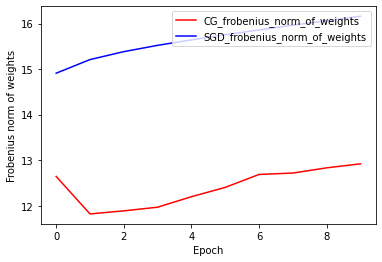

In [13]:
plt.plot(
    CG_frobenius_norm_of_weight,
    color='r',
    label='CG_frobenius_norm_of_weights')
plt.plot(
    SGD_frobenius_norm_of_weight,
    color='b',
    label='SGD_frobenius_norm_of_weights')
plt.xlabel('Epoch')
plt.ylabel('Frobenius norm of weights')
plt.legend(loc=1)

# トレーニングと検証の精度：CGとSGDの比較


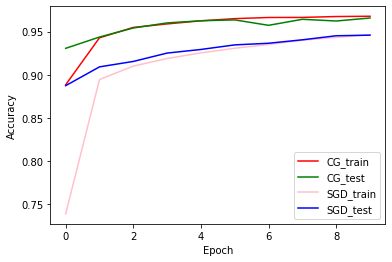

In [14]:
plt.plot(history_cg.history['accuracy'], color='r', label='CG_train')
plt.plot(history_cg.history['val_accuracy'], color='g', label='CG_test')
plt.plot(history_sgd.history['accuracy'], color='pink', label='SGD_train')
plt.plot(history_sgd.history['val_accuracy'], color='b', label='SGD_test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=4)